In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 20c: 

## LSTM - Weather data


<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
# Lets import some libraries
import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf

%matplotlib inline

2023-12-17 17:53:32.005763: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-17 17:53:32.068623: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-17 17:53:32.068676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-17 17:53:32.070531: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-17 17:53:32.082436: I tensorflow/core/platform/cpu_feature_guar

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
# Strictly for tensorflow version 2.12
### To hide bugs throwing warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
# Some basic parameters

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results

EPOCHS = 500  # number of cycles to run

ALPHA = 0.1  # learning rate

TEST_SIZE = 0.2 # What fraction we want to keep for testing

BATCH_SIZE = 256

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (12,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }
CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

## Helper Function

In [6]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def plot_tf_hist(hist_df):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

## Load Weather Data
Source: [Kaggle](https://www.kaggle.com/muthuj7/weather-dataset)

In [7]:
dataFilename = 'weatherHistory.csv'
data_df = pd.read_csv(os.path.join(inpDir, dataFilename))
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [8]:
data_df.shape

(96453, 12)

In [9]:
data_df['datetime'] = pd.to_datetime(data_df['Formatted Date'], utc=True)

In [10]:
temp_df = data_df[['datetime', 'Temperature (C)']]
temp_df = temp_df.sort_values('datetime', axis=0, ascending=True)
temp_df = temp_df.reset_index(drop=True)
temp_df.head()

,datetime,Temperature (C)
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


In [11]:
temp_df = temp_df.rename({'Temperature (C)': 'temp'}, axis=1)
temp_df.head()

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


In [12]:
# comment / uncomment following lines if you want part or full dataset

startDate = pd.to_datetime('2007-1-1', utc=True)
endDate = pd.to_datetime('2008-1-1', utc=True)
#temp_df = temp_df[(temp_df['datetime']  >= startDate) & (temp_df['datetime']  < endDate)]

In [13]:
temp_df.reset_index(drop=True, inplace = True)
temp_df.head()

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


In [14]:
temp_df.shape

(96453, 2)

## Plotting samples

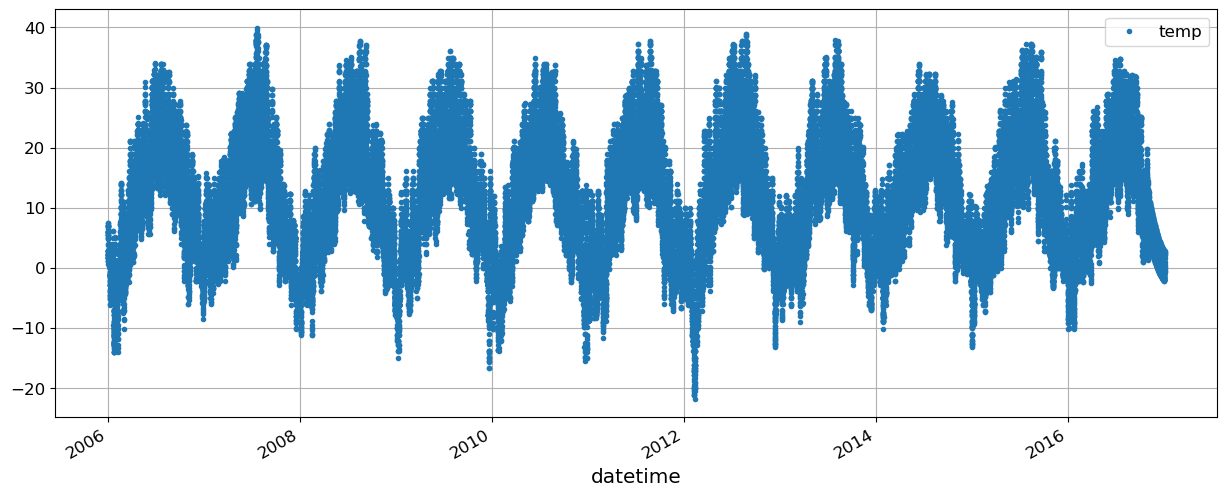

In [15]:
fig, ax = plt.subplots(figsize = (15,6))
temp_df.plot(x='datetime', y='temp', style=".", ax = ax);
ax.grid()

In [16]:
time_step = 24

In [17]:
y_idx = np.arange(time_step, temp_df.shape[0], time_step)
y_df = temp_df.iloc[y_idx]
y_df.head()

,datetime,temp
24,2006-01-01 23:00:00+00:00,5.422222
48,2006-01-02 23:00:00+00:00,1.694444
72,2006-01-03 23:00:00+00:00,2.200000
96,2006-01-04 23:00:00+00:00,1.666667
120,2006-01-05 23:00:00+00:00,1.805556


In [18]:
y_df.shape, len(y_df)*time_step

((4018, 2), 96432)

In [19]:
temp_df.shape

(96453, 2)

In [20]:
X_df = temp_df.iloc[range(len(y_df) * time_step)]

In [21]:
X_df['temp'].values.shape

(96432,)

In [22]:
X = np.reshape(X_df['temp'].values, (y_df.shape[0], time_step))
X.shape

(4018, 24)

In [23]:
X = X[:, :23]
X.shape

(4018, 23)

In [24]:
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [25]:
split = int(y_df.shape[0] * (1-TEST_SIZE))
X_train = X[:split]
X_test = X[split:]
y_train = y_df['temp'].values[:split]
y_test = y_df['temp'].values[split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((3214, 23, 1), (804, 23, 1), (3214,), (804,))

In [26]:
scaler = StandardScaler()
# transform data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [27]:
h_units = 256

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(h_units, activation ='tanh',
                               input_shape= (X_train.shape[1],X_train.shape[2]),
                               kernel_regularizer = 'l2'))

model.add(tf.keras.layers.Dense(128, 
                                activation ='tanh', 
                                kernel_regularizer = 'l2'))

model.add(tf.keras.layers.Dense(1, 
                                activation ='linear'))

model.compile(loss= 'mean_squared_error', optimizer = 'adam',
             metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 297217 (1.13 MB)
Trainable params: 297217 (1.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
history = model.fit ( X_train, y_train,
                     epochs = EPOCHS,
                     validation_data = (X_test, y_test),
                     batch_size = BATCH_SIZE,
                     verbose=2)

Epoch 1/500
13/13 - 5s - loss: 82.3449 - root_mean_squared_error: 8.9786 - val_loss: 31.0411 - val_root_mean_squared_error: 5.4127 - 5s/epoch - 396ms/step
Epoch 2/500
13/13 - 2s - loss: 20.9603 - root_mean_squared_error: 4.3842 - val_loss: 16.1728 - val_root_mean_squared_error: 3.8003 - 2s/epoch - 135ms/step
Epoch 3/500
13/13 - 2s - loss: 14.7994 - root_mean_squared_error: 3.6163 - val_loss: 9.4183 - val_root_mean_squared_error: 2.7764 - 2s/epoch - 134ms/step
Epoch 4/500
13/13 - 2s - loss: 9.9693 - root_mean_squared_error: 2.8752 - val_loss: 7.0237 - val_root_mean_squared_error: 2.3087 - 2s/epoch - 133ms/step
Epoch 5/500
13/13 - 2s - loss: 7.8182 - root_mean_squared_error: 2.4762 - val_loss: 5.8480 - val_root_mean_squared_error: 2.0421 - 2s/epoch - 131ms/step
Epoch 6/500
13/13 - 2s - loss: 6.9972 - root_mean_squared_error: 2.3080 - val_loss: 5.7279 - val_root_mean_squared_error: 2.0169 - 2s/epoch - 133ms/step
Epoch 7/500
13/13 - 2s - loss: 6.4741 - root_mean_squared_error: 2.1958 - val

In [29]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,82.344933,8.978626,31.041140,5.412700
1,20.960253,4.384217,16.172791,3.800284
2,14.799402,3.616318,9.418290,2.776387
3,9.969296,2.875221,7.023664,2.308696
4,7.818189,2.476171,5.847983,2.042094


In [30]:
hist_df = hist_df.rename({'root_mean_squared_error': 'rmse', 
                          'val_root_mean_squared_error': 'val_rmse'}, 
                         axis = 1)
hist_df.head()

,loss,rmse,val_loss,val_rmse
0,82.344933,8.978626,31.041140,5.412700
1,20.960253,4.384217,16.172791,3.800284
2,14.799402,3.616318,9.418290,2.776387
3,9.969296,2.875221,7.023664,2.308696
4,7.818189,2.476171,5.847983,2.042094


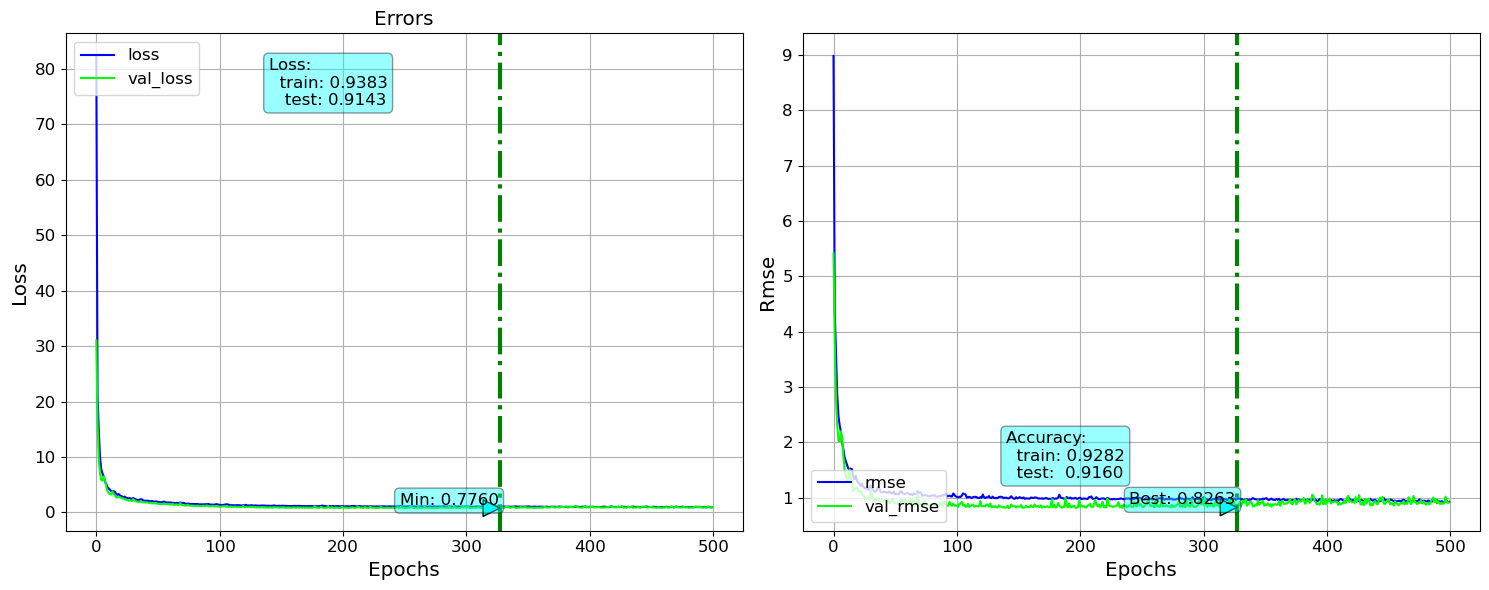

In [31]:
plot_tf_hist(hist_df)

In [32]:
# make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_pred = np.append(y_train_pred, y_test_pred)

26/26 [==============================] - 1s 19ms/step


In [33]:
res_df = y_df.copy()

res_df['pred'] = y_pred
#res_df['datetime'] = res_df['datetime'].dt.date
res_df.head()

,datetime,temp,pred
24,2006-01-01 23:00:00+00:00,5.422222,5.154013
48,2006-01-02 23:00:00+00:00,1.694444,1.732621
72,2006-01-03 23:00:00+00:00,2.200000,2.129019
96,2006-01-04 23:00:00+00:00,1.666667,2.104814
120,2006-01-05 23:00:00+00:00,1.805556,2.607270


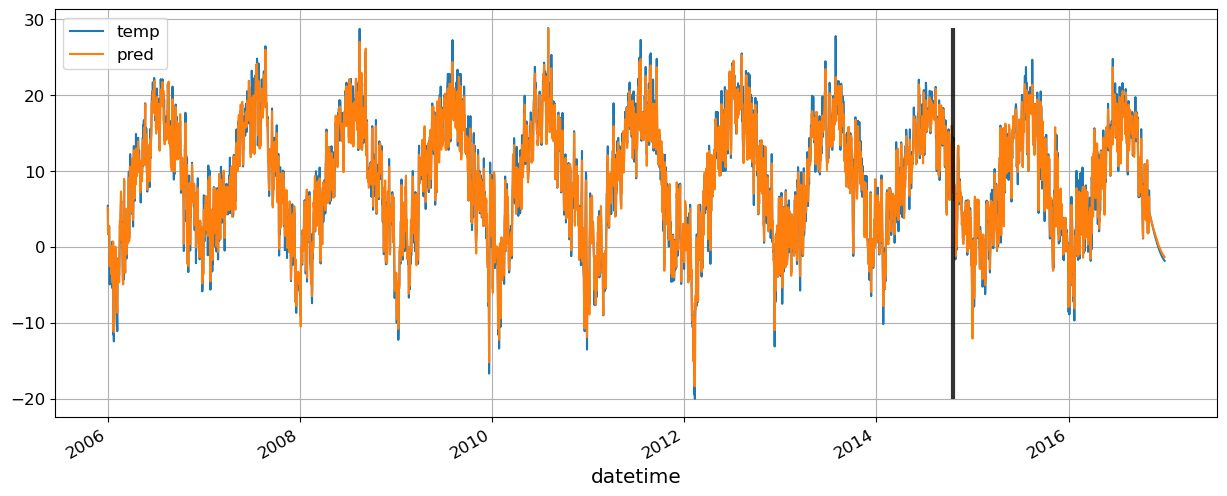

In [34]:
fig, ax = plt.subplots(figsize = (15,6))

res_df.plot(x='datetime', y=['temp','pred'], ax = ax);

ax.vlines(y_df.iloc[X_train.shape[0]]['datetime'], 
          y_df['temp'].min(), 
          y_df['temp'].max(), color = 'k', 
          linewidth=3.0, zorder=10, alpha =0.8)

ax.grid()